In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [10]:
dataset = tfds.load("kmnist", split=["train", "test"], as_supervised=True)
train_data, test_data = dataset

In [11]:
train_images = np.array([image.numpy() for image, label in train_data])
train_labels = np.array([label.numpy() for image, label in train_data])
test_images = np.array([image.numpy() for image, label in test_data])
test_labels = np.array([label.numpy() for image, label in test_data])

In [12]:
train_images = train_images.reshape(-1, 784).astype("float32") / 255.0
test_images = test_images.reshape(-1, 784).astype("float32") / 255.0

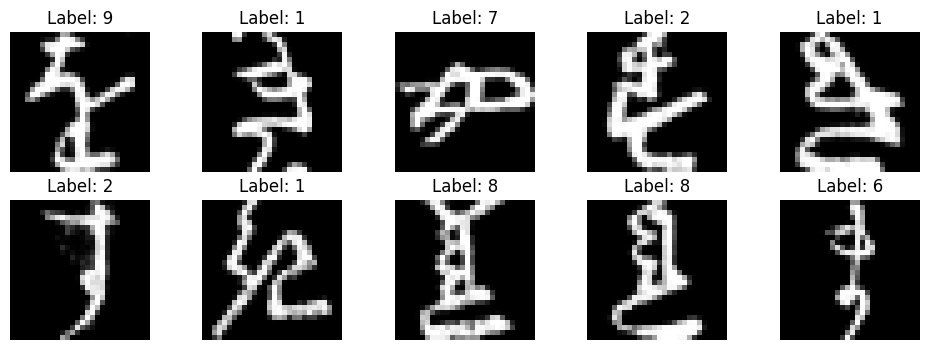

In [13]:
def show_samples(images, labels, num_samples=10):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

show_samples(train_images, train_labels)

In [14]:
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

val_split = int(0.1 * len(train_images))
val_images, train_images = train_images[:val_split], train_images[val_split:]
val_labels, train_labels = train_labels[:val_split], train_labels[val_split:]

In [15]:
def create_model(hidden_layers=[128, 64], activation='relu', optimizer='adam', weight_decay=0.0005):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation=activation, input_shape=(784,), kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    model.add(Dense(10, activation='softmax'))


    if optimizer == 'sgd':
        opt = SGD(learning_rate=0.001)
    elif optimizer == 'momentum':
        opt = SGD(learning_rate=0.001, momentum=0.9)
    elif optimizer == 'nesterov':
        opt = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=0.001)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=0.001)


    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [16]:
configs = [
    {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'weight_decay': 0.0005},
    {'hidden_layers': [128, 128, 64], 'activation': 'relu', 'optimizer': 'sgd', 'weight_decay': 0},
    {'hidden_layers': [256, 128, 64], 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'weight_decay': 0.0005},
    {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'nesterov', 'weight_decay': 0.0005},
]

In [17]:
best_model = None
best_acc = 0.0
best_config = None
results = []

In [21]:

def backward_pass(model, gradients):
    with tf.GradientTape() as tape:
        loss = model.loss
    return tape.gradient(loss, model.trainable_variables)


def update_weights(model, gradients, optimizer):
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [18]:
for config in configs:
    print(f"\nTraining model with config: {config}")
    model = create_model(**config)
    history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(val_images, val_labels), verbose=1)

    val_acc = max(history.history['val_accuracy'])  # Get best validation accuracy
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

    # Store the result
    results.append({
        'Hidden Layers': config['hidden_layers'],
        'Activation': config['activation'],
        'Optimizer': config['optimizer'],
        'Weight Decay': config['weight_decay'],
        'Best Validation Accuracy': val_acc,
        'Test Accuracy': test_acc
    })

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_config = config

print(f"\nBest Model Configuration: {best_config} with Validation Accuracy: {best_acc:.4f}")



Training model with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'weight_decay': 0.0005}
Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8143 - loss: 0.7611 - val_accuracy: 0.9228 - val_loss: 0.4157
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9362 - loss: 0.3558 - val_accuracy: 0.9400 - val_loss: 0.3389
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9512 - loss: 0.3018 - val_accuracy: 0.9433 - val_loss: 0.3260
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9551 - loss: 0.2802 - val_accuracy: 0.9413 - val_loss: 0.3323
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9607 - loss: 0.2555 - val_accuracy: 0.9498 - val_loss: 0.2939
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9648 - loss: 0.2421 - val_accuracy: 0.9525 - val_loss: 0.2912
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9660 - loss: 0.2370 - val_a

In [19]:
df_results = pd.DataFrame(results)
print("\nComparison of Model Configurations:")
print(df_results)

test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f"\nBest Model Test Accuracy: {test_acc * 100:.2f}%")





Comparison of Model Configurations:
    Hidden Layers Activation Optimizer  Weight Decay  \
0       [128, 64]       relu      adam        0.0005   
1  [128, 128, 64]       relu       sgd        0.0000   
2  [256, 128, 64]    sigmoid   rmsprop        0.0005   
3   [128, 64, 32]       relu  nesterov        0.0005   

   Best Validation Accuracy  Test Accuracy  
0                  0.953000         0.8883  
1                  0.840333         0.7126  
2                  0.900333         0.7881  
3                  0.935167         0.8638  
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8901 - loss: 0.5106

Best Model Test Accuracy: 88.83%


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


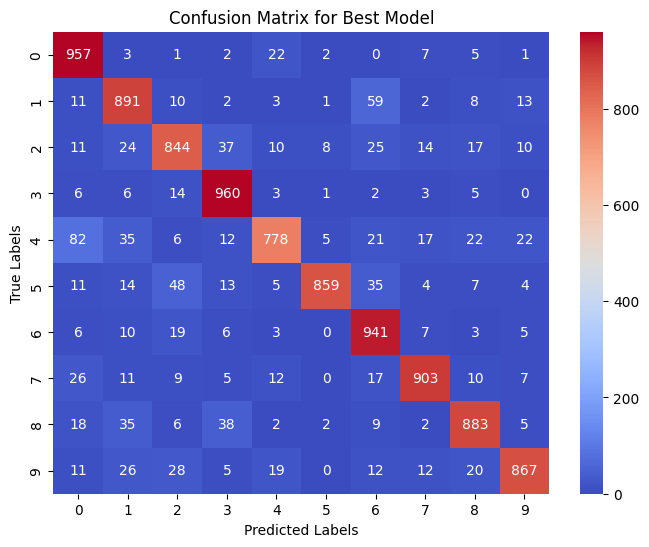

In [20]:
y_pred = best_model.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Best Model')
plt.show()